# SDAB Melting Temperature Prediction using DL

### Load Modules and Datasets

In [1]:
### Initialize seed for reproducibility
import numpy as np
np.random.seed(0)
import math

### Data Wrangling and Plots
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
import keras

2024-09-08 17:24:45.650793: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-08 17:24:45.673350: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def split_biased(data, y, split_column='source', holdout_var = "Camel"):
    """
    Create a split that holds out one group and splits the other one.
    """
    # data set for training
    x_train_all = data[meta[split_column] != holdout_var]
    y_train_all = y[meta[split_column] != holdout_var]

    #data set for validation
    x_val = data[meta[split_column] == holdout_var]
    y_val = y[meta[split_column] == holdout_var]

    #train, test split
    x_train, x_test, y_train, y_test = train_test_split(x_train_all, y_train_all, test_size=0.2, random_state=42)

    return x_train, y_train, x_test, y_test, x_val, y_val

### DL Model: Keras Sequential API for ANN

In [3]:
def create_model():
    model = Sequential([
        keras.layers.Dense(128, 
                           input_shape = (x.shape[1],), # input shape is the number of predictors
                           activation = 'relu'), # Input Layer
        keras.layers.Dense(256, 
                           activation = 'relu'), # Hidden Layer (mean of neurons in the input and output layers.)
        keras.layers.Dense(256, 
                           activation = 'relu'), # Hidden Layer (mean of neurons in the input and output layers.)
        keras.layers.Dense(256, 
                           activation = 'relu'), # Hidden Layer (mean of neurons in the input and output layers.)
        keras.layers.Dense(1, 
                           activation = 'linear') # If the NN is a regressor, then the output layer has a single node.
    ])
    
    model.compile(
        loss = 'mae',
        optimizer = 'adam',
        metrics= ['mae']
    )
    
    model.summary()

    return model

In [4]:
def compute_accuracies(model, x_test, y_test):
    """
    Compute the accuracies
    """

    mae = mean_absolute_error(y_test, model.predict(x_test))
    rmse = math.sqrt(mean_squared_error(y_test, model.predict(x_test)))
    coeff_det=r2_score(y_test, model.predict(x_test))
    return mae, rmse, coeff_det
    

#### Read training data from datafolder

In [5]:
data = pd.read_csv("../data/sdab_protein_embeddings_t6.csv", header = None)
data.head()
meta = pd.read_csv('../data/augmented_metadata.tsv')
y = pd.read_excel("../data/sdab_data.xlsx")

y = y.tm
x = data

In [6]:
meta.loc[meta.source.isin(['Arabian camel (Camelus dromedarius)', 'Dromedary']), 'source'] = "Dromedary"

# Biased trainings
## Split by species

In [7]:
species = ['Llama', 'Unknown', 'Camel', 'Alpaca', 'Human', 'Dromedary']
list_of_error = []
for animal in species:
    print(animal)
    x_train, y_train, x_test, y_test, x_val, y_val = split_biased(data, y, split_column='source', holdout_var = animal)
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    model = create_model()
    model_history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_test, y_test), callbacks=callback)
    mae, rmse, coeff_det = compute_accuracies(model, x_val, y_val)
    list_of_error.append([animal, mae, rmse, coeff_det])

Llama


/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 67.6538 - mae: 67.6538 - val_loss: 59.5119 - val_mae: 59.5119
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 57.7994 - mae: 57.7994 - val_loss: 31.2968 - val_mae: 31.2968
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.0985 - mae: 24.0985 - val_loss: 20.2345 - val_mae: 20.2345
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.2456 - mae: 13.2456 - val_loss: 11.3424 - val_mae: 11.3424
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.7929 - mae: 11.7929 - val_loss: 11.5882 - val_mae: 11.5882
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.6472 - mae: 10.6472 - val_loss: 7.8044 - val_mae: 7.8044
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6136 - mae: 8.6136 - val_loss: 8.2914 - val_mae: 8.2914
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4927 - mae: 8.4927 - val_loss: 7.6156 - val_mae: 7.6156
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 64.2158 - mae: 64.2158 - val_loss: 30.8115 - val_mae: 30.8115
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.1450 - mae: 18.1450 - val_loss: 13.1599 - val_mae: 13.1599
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.3213 - mae: 10.3213 - val_loss: 9.1009 - val_mae: 9.1009
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0876 - mae: 8.0876 - val_loss: 8.8554 - val_mae: 8.8554
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0914 - mae: 8.0914 - val_loss: 8.1816 - val_mae: 8.1816
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4863 - mae: 7.4863 - val_loss: 8.0738 - val_mae: 8.0738
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5028 - mae: 7.5028 - val_loss: 8.4707 - val_mae: 8.4707
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3223 - mae: 7.3223 - val_loss: 7.5816 - val_mae: 7.5816
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 64.5734 - mae: 64.5734 - val_loss: 56.7482 - val_mae: 56.7482
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.4785 - mae: 45.4785 - val_loss: 15.9656 - val_mae: 15.9656
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.3795 - mae: 15.3795 - val_loss: 12.9909 - val_mae: 12.9909
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9904 - mae: 9.9904 - val_loss: 9.1919 - val_mae: 9.1919
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5237 - mae: 9.5237 - val_loss: 8.0832 - val_mae: 8.0832
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5639 - mae: 8.5639 - val_loss: 8.2187 - val_mae: 8.2187
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4975 - mae: 8.4975 - val_loss: 7.9276 - val_mae: 7.9276
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9983 - mae: 7.9983 - val_loss: 7.8129 - val_mae: 7.8129
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 65.7897 - mae: 65.7897 - val_loss: 39.7170 - val_mae: 39.7170
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.8558 - mae: 24.8558 - val_loss: 12.5373 - val_mae: 12.5373
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.9450 - mae: 11.9450 - val_loss: 9.1895 - val_mae: 9.1895
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3903 - mae: 8.3903 - val_loss: 9.4897 - val_mae: 9.4897
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9789 - mae: 7.9789 - val_loss: 8.9059 - val_mae: 8.9059
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2457 - mae: 8.2457 - val_loss: 8.9962 - val_mae: 8.9962
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6028 - mae: 7.6028 - val_loss: 8.4073 - val_mae: 8.4073
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9460 - mae: 7.9460 - val_loss: 8.5666 - val_mae: 8.5666
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 64.6601 - mae: 64.6601 - val_loss: 25.4436 - val_mae: 25.4436
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.2325 - mae: 17.2325 - val_loss: 10.7893 - val_mae: 10.7893
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4323 - mae: 9.4323 - val_loss: 9.5191 - val_mae: 9.5191
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6702 - mae: 8.6702 - val_loss: 9.1448 - val_mae: 9.1448
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0346 - mae: 8.0346 - val_loss: 9.0548 - val_mae: 9.0548
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4646 - mae: 8.4646 - val_loss: 9.2672 - val_mae: 9.2672
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0644 - mae: 8.0644 - val_loss: 8.7274 - val_mae: 8.7274
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8810 - mae: 7.8810 - val_loss: 8.6052 - val_mae: 8.6052
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - los

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 65.6849 - mae: 65.6849 - val_loss: 40.9947 - val_mae: 40.9947
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.8288 - mae: 24.8288 - val_loss: 13.6098 - val_mae: 13.6098
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.4349 - mae: 12.4349 - val_loss: 8.8706 - val_mae: 8.8706
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1080 - mae: 9.1080 - val_loss: 8.5825 - val_mae: 8.5825
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2249 - mae: 8.2249 - val_loss: 8.4760 - val_mae: 8.4760
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1814 - mae: 8.1814 - val_loss: 8.6943 - val_mae: 8.6943
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6947 - mae: 7.6947 - val_loss: 8.2177 - val_mae: 8.2177
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7912 - mae: 7.7912 - val_loss: 8.4823 - val_mae: 8.4823
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

## Split into train/test and validation set 

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model = create_model()
model_history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_test, y_test), callbacks=callback)
amae, armse, acoeff_det = compute_accuracies(model, x_val, y_val)
list_of_error.append(['all', amae, armse, acoeff_det])

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 66.0882 - mae: 66.0882 - val_loss: 51.0451 - val_mae: 51.0451
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.7786 - mae: 36.7786 - val_loss: 13.3108 - val_mae: 13.3108
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.5914 - mae: 11.5914 - val_loss: 9.7085 - val_mae: 9.7085
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2582 - mae: 9.2582 - val_loss: 9.0914 - val_mae: 9.0914
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5078 - mae: 8.5078 - val_loss: 8.2159 - val_mae: 8.2159
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3081 - mae: 8.3081 - val_loss: 8.2352 - val_mae: 8.2352
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6433 - mae: 7.6433 - val_loss: 8.3640 - val_mae: 8.3640
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6213 - mae: 7.6213 - val_loss: 7.8826 - val_mae: 7.8826
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

## Collect all results

In [9]:
results1 = pd.DataFrame(list_of_error)
results1.columns = ['Species', 'MAE', 'RMSE', 'R2']
df_melted = results1.melt(id_vars='Species', value_vars=['MAE', 'RMSE', 'R2'], var_name='Metric', value_name='Value')
df_melted['color'] = 'black'
df_melted.loc[df_melted.Species == 'all', 'color']= 'red'

In [10]:
results1

,Species,MAE,RMSE,R2
0,Llama,7.421335,9.175770,0.138215
1,Unknown,11.214516,12.488434,0.124509
2,Camel,6.768432,8.499747,0.171504
3,Alpaca,5.394549,7.012836,0.366218
4,Human,4.616089,4.670746,0.483648
5,Dromedary,6.313409,7.622675,-0.102263
6,all,5.962997,7.590841,0.485403


## Compare the error achieved when training on a random dataset compare to the error when training on a biased split

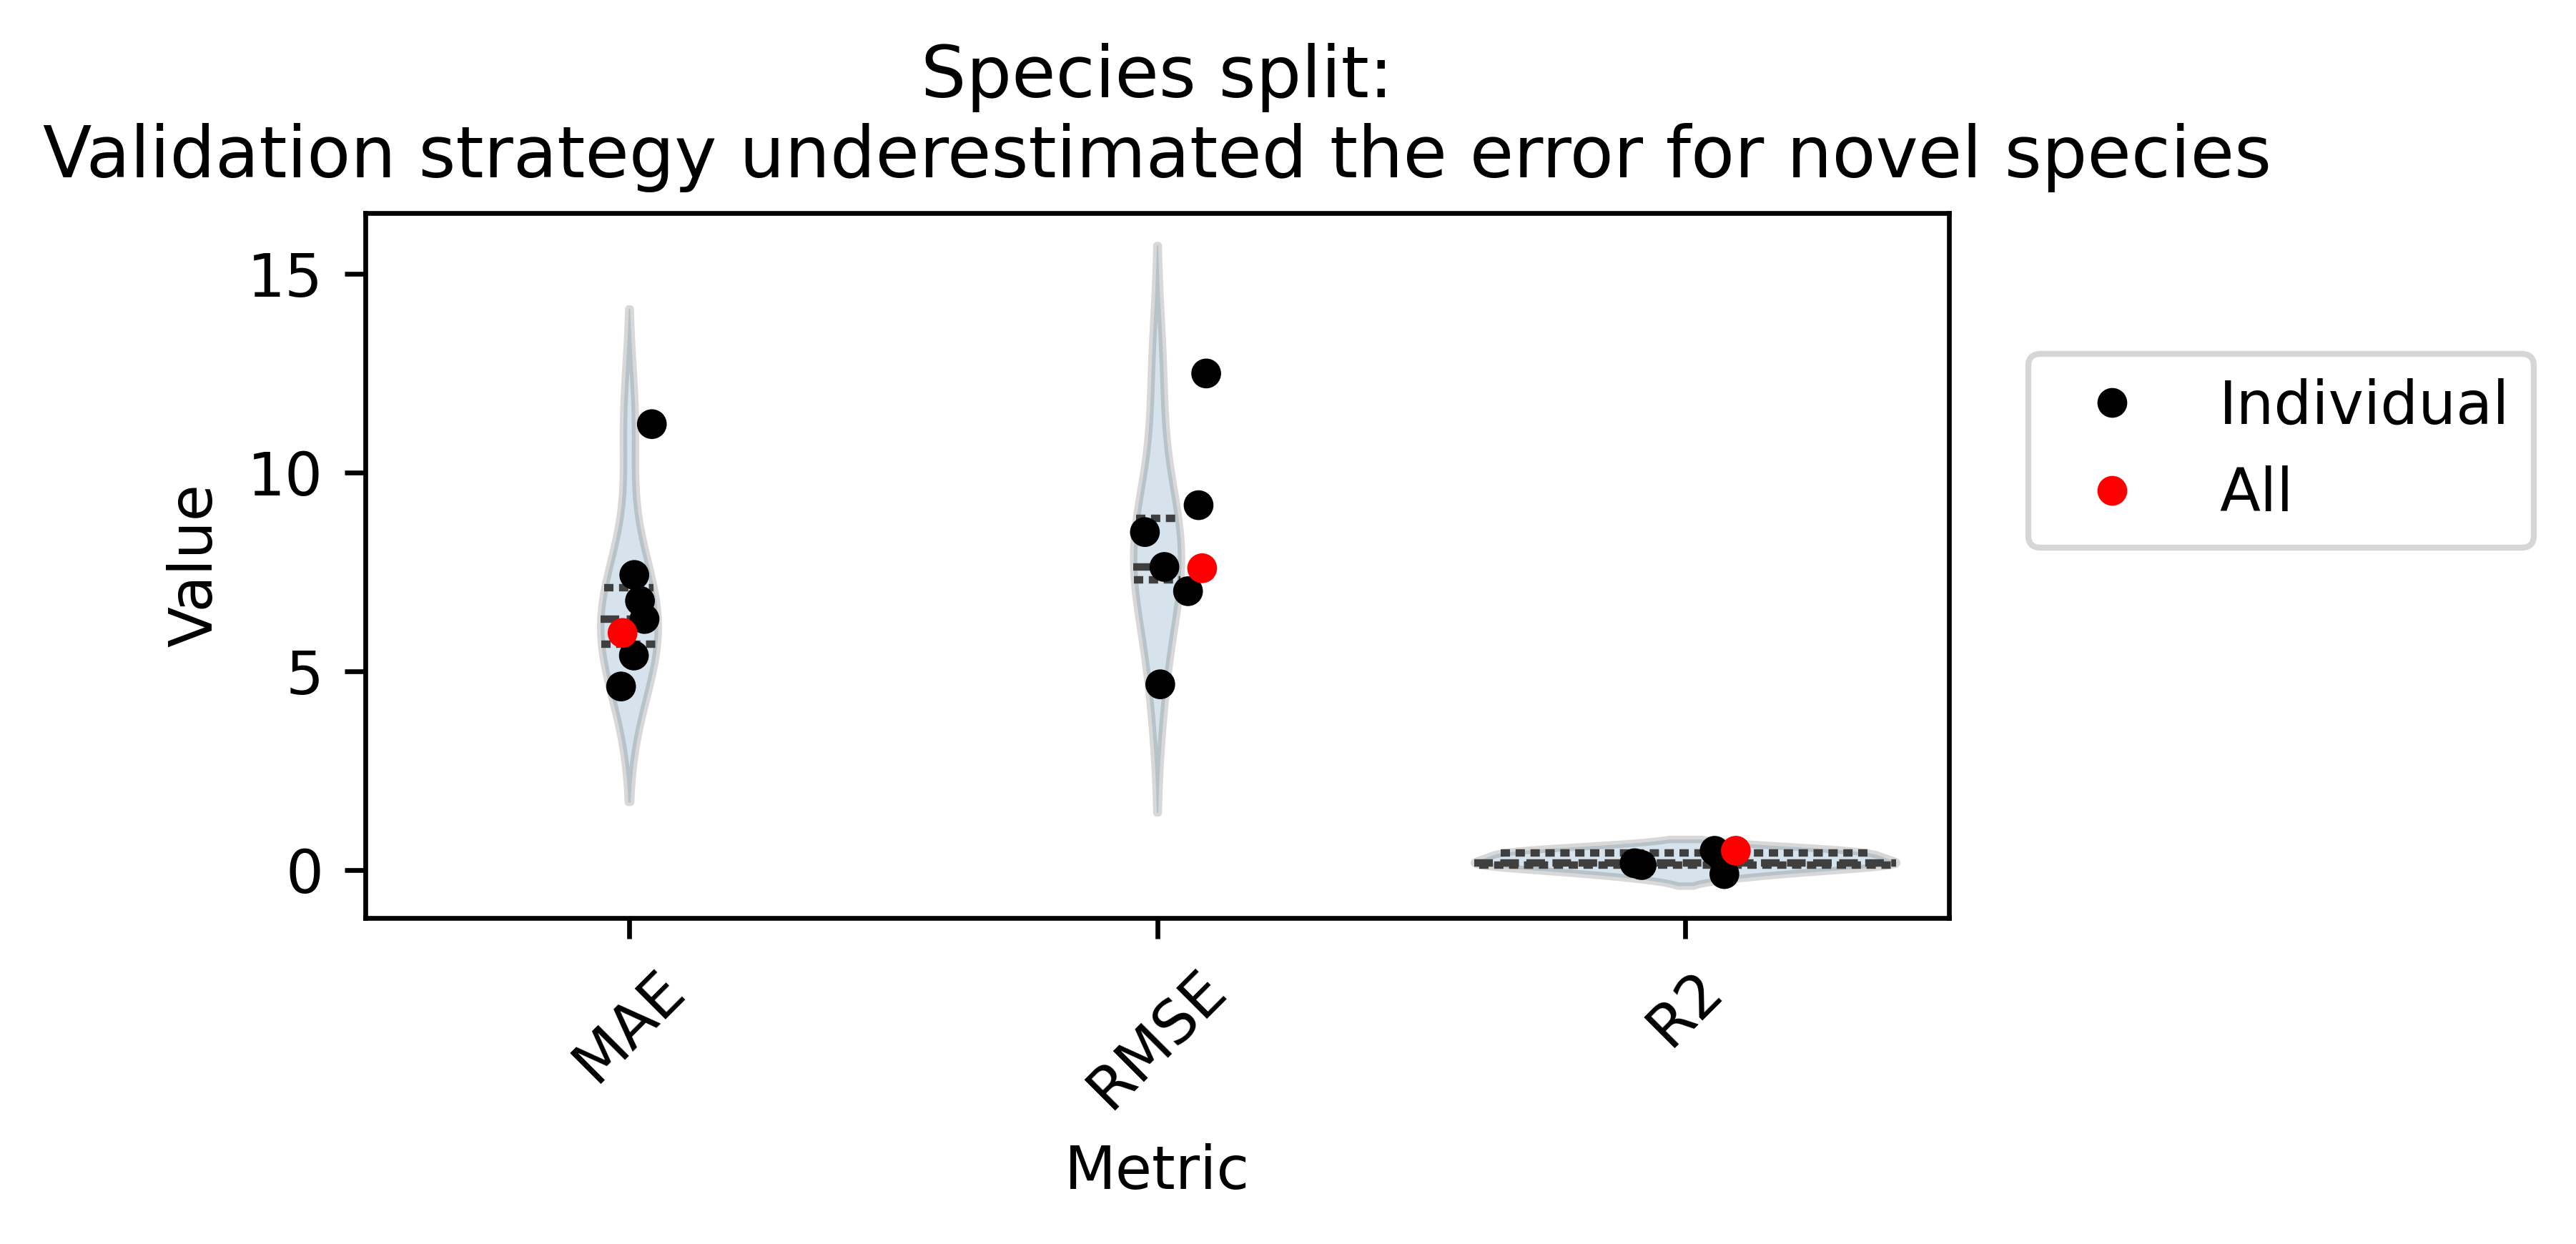

In [11]:
# Creating the boxplot
plt.figure(figsize=(6, 3))
sns.violinplot(x='Metric', y='Value', data=df_melted, alpha=0.2,inner='quart' )
plt.title('Species split:\nValidation strategy underestimated the error for novel species')
plt.xticks(rotation=45)
sns.stripplot(
    x='Metric', y='Value', data=df_melted,
    hue='color', dodge=False, palette={'red': 'red', 'black': 'black'}, jitter=True, marker='o',
)

handles, labels = plt.gca().get_legend_handles_labels()

# Combine handles and labels manually to update red point labels
species_labels = ['Individual', 'All']
color_labels = ['Red Points (Alpaca & Dromedary)', 'Grey Points (Other Species)']

# Use only necessary handles and labels and set them accordingly
plt.legend(
    handles[:len(species_labels)]  , # Keep species and last 2 for colors
    species_labels + color_labels,                 # Combine species and color labels
    bbox_to_anchor=(1.05, 0.8), 
    loc='upper left', 
    borderaxespad=0.
)

plt.tight_layout()
plt.savefig('../figures/species_split.png', dpi=300, bbox_inches='tight')

plt.show()

## Comute stats for homology splits
### Compute the error when splitting by 2,3, and 4 homology clusters

In [12]:
list_of_error = []
for column in [f'split_{i}' for i in range(2,5)]:
    for animal in meta[column].unique():
        print(animal)
        x_train, y_train, x_test, y_test, x_val, y_val = split_biased(data, y, split_column=column, holdout_var = animal)
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        model = create_model()
        model_history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_test, y_test), callbacks=callback)
        mae, rmse, coeff_det = compute_accuracies(model, x_val, y_val)
        list_of_error.append([column, animal, mae, rmse, coeff_det])

0


/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 75.9307 - mae: 75.9307 - val_loss: 77.1142 - val_mae: 77.1142
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 74.9049 - mae: 74.9049 - val_loss: 75.9538 - val_mae: 75.9538
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 74.1352 - mae: 74.1352 - val_loss: 74.0119 - val_mae: 74.0119
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 71.8798 - mae: 71.8798 - val_loss: 70.8671 - val_mae: 70.8671
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 68.9087 - mae: 68.9087 - val_loss: 65.8875 - val_mae: 65.8875
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 63.3011 - mae: 63.3011 - val_loss: 58.2013 - val_mae: 58.2013
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 55.1916 - mae: 55.1916 - val_loss: 46.6168 - val_mae: 46.6168
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 42.3790 - mae: 42.3790 - val_loss: 29.6092 - val_mae: 29.6092
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 62.8072 - mae: 62.8072 - val_loss: 36.5442 - val_mae: 36.5442
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.8975 - mae: 22.8975 - val_loss: 11.6653 - val_mae: 11.6653
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.4424 - mae: 10.4424 - val_loss: 8.0254 - val_mae: 8.0254
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2156 - mae: 8.2156 - val_loss: 8.2474 - val_mae: 8.2474
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8547 - mae: 7.8547 - val_loss: 7.7601 - val_mae: 7.7601
Epoch 6/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6593 - mae: 7.6593 - val_loss: 7.7975 - val_mae: 7.7975
Epoch 7/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9174 - mae: 7.9174 - val_loss: 7.5803 - val_mae: 7.5803
Epoch 8/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2093 - mae: 8.2093 - val_loss: 8.0259 - val_mae: 8.0259
Epoch 9/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 77.2595 - mae: 77.2595 - val_loss: 74.3833 - val_mae: 74.3833
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 76.9113 - mae: 76.9113 - val_loss: 73.3501 - val_mae: 73.3501
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 75.5907 - mae: 75.5907 - val_loss: 71.6151 - val_mae: 71.6151
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 73.7258 - mae: 73.7258 - val_loss: 68.7213 - val_mae: 68.7213
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 70.3549 - mae: 70.3549 - val_loss: 64.0935 - val_mae: 64.0935
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 65.2391 - mae: 65.2391 - val_loss: 56.7965 - val_mae: 56.7965
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 57.6198 - mae: 57.6198 - val_loss: 45.5880 - val_mae: 45.5880
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 45.7268 - mae: 45.7268 - val_loss: 28.9033 - val_mae: 28.9033
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 63.6085 - mae: 63.6085 - val_loss: 38.5128 - val_mae: 38.5128
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.6366 - mae: 23.6366 - val_loss: 14.0281 - val_mae: 14.0281
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.2998 - mae: 14.2998 - val_loss: 9.5441 - val_mae: 9.5441
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6989 - mae: 7.6989 - val_loss: 8.2429 - val_mae: 8.2429
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3060 - mae: 8.3060 - val_loss: 8.3429 - val_mae: 8.3429
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6298 - mae: 7.6298 - val_loss: 8.1986 - val_mae: 8.1986
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7034 - mae: 7.7034 - val_loss: 8.2281 - val_mae: 8.2281
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1094 - mae: 8.1094 - val_loss: 8.1988 - val_mae: 8.1988
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 63.2799 - mae: 63.2799 - val_loss: 29.9070 - val_mae: 29.9070
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.1594 - mae: 19.1594 - val_loss: 10.8090 - val_mae: 10.8090
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.2922 - mae: 10.2922 - val_loss: 8.8877 - val_mae: 8.8877
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8162 - mae: 8.8162 - val_loss: 8.3168 - val_mae: 8.3168
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7710 - mae: 8.7710 - val_loss: 8.1508 - val_mae: 8.1508
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2568 - mae: 8.2568 - val_loss: 8.1061 - val_mae: 8.1061
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8957 - mae: 7.8957 - val_loss: 8.0841 - val_mae: 8.0841
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7087 - mae: 7.7087 - val_loss: 8.0332 - val_mae: 8.0332
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 74.0468 - mae: 74.0468 - val_loss: 71.6356 - val_mae: 71.6356
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 72.0365 - mae: 72.0365 - val_loss: 69.5356 - val_mae: 69.5356
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 69.4914 - mae: 69.4914 - val_loss: 65.0894 - val_mae: 65.0894
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 64.6577 - mae: 64.6577 - val_loss: 56.1933 - val_mae: 56.1933
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 55.2456 - mae: 55.2456 - val_loss: 39.3673 - val_mae: 39.3673
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 36.9334 - mae: 36.9334 - val_loss: 11.9631 - val_mae: 11.9631
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.5061 - mae: 11.5061 - val_loss: 24.7347 - val_mae: 24.7347
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 22.1280 - mae: 22.1280 - val_loss: 12.6283 - val_mae: 12.6283
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_65 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 63.5534 - mae: 63.5534 - val_loss: 36.2275 - val_mae: 36.2275
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.3898 - mae: 21.3898 - val_loss: 12.5317 - val_mae: 12.5317
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.4484 - mae: 10.4484 - val_loss: 10.1959 - val_mae: 10.1959
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6731 - mae: 8.6731 - val_loss: 8.4801 - val_mae: 8.4801
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1169 - mae: 8.1169 - val_loss: 8.6428 - val_mae: 8.6428
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3561 - mae: 8.3561 - val_loss: 8.4143 - val_mae: 8.4143
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9861 - mae: 7.9861 - val_loss: 8.5762 - val_mae: 8.5762
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1741 - mae: 8.1741 - val_loss: 9.8820 - val_mae: 9.8820
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 64.4188 - mae: 64.4188 - val_loss: 35.2951 - val_mae: 35.2951
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.4201 - mae: 22.4201 - val_loss: 12.8871 - val_mae: 12.8871
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.3044 - mae: 12.3044 - val_loss: 9.2703 - val_mae: 9.2703
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2488 - mae: 9.2488 - val_loss: 8.9192 - val_mae: 8.9192
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1555 - mae: 8.1555 - val_loss: 8.5198 - val_mae: 8.5198
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5112 - mae: 7.5112 - val_loss: 8.5921 - val_mae: 8.5921
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7111 - mae: 7.7111 - val_loss: 8.8508 - val_mae: 8.8508
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1146 - mae: 8.1146 - val_loss: 7.8477 - val_mae: 7.8477
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 64.2103 - mae: 64.2103 - val_loss: 27.3378 - val_mae: 27.3378
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.4074 - mae: 19.4074 - val_loss: 14.9051 - val_mae: 14.9051
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.6829 - mae: 12.6829 - val_loss: 8.7064 - val_mae: 8.7064
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8711 - mae: 8.8711 - val_loss: 8.1649 - val_mae: 8.1649
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0357 - mae: 9.0357 - val_loss: 8.1274 - val_mae: 8.1274
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3402 - mae: 8.3402 - val_loss: 8.5941 - val_mae: 8.5941
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7416 - mae: 8.7416 - val_loss: 7.8398 - val_mae: 7.8398
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0912 - mae: 8.0912 - val_loss: 8.0248 - val_mae: 8.0248
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

## Append the standard training error from earlier.

In [13]:
list_of_error.append(['all','all', amae, armse, acoeff_det])

In [14]:
results2 = pd.DataFrame(list_of_error)
results2.columns = ['clusters','Species', 'MAE', 'RMSE', 'R2']
df_melted = results2.melt(id_vars=['Species', 'clusters'], value_vars=['MAE', 'RMSE', 'R2'], var_name='Metric', value_name='Value')
df_melted['color'] = 'black'
df_melted.loc[df_melted.Species == 'all', 'color']= 'red'

In [15]:
df_melted

,Species,clusters,Metric,Value,color
0,0,split_2,MAE,11.841194,black
1,1,split_2,MAE,6.845415,black
2,0,split_3,MAE,12.521957,black
3,1,split_3,MAE,8.110009,black
4,2,split_3,MAE,4.717075,black
5,0,split_4,MAE,9.718700,black
6,3,split_4,MAE,5.521296,black
7,1,split_4,MAE,3.504166,black
8,2,split_4,MAE,6.872806,black
9,all,all,MAE,5.962997,red


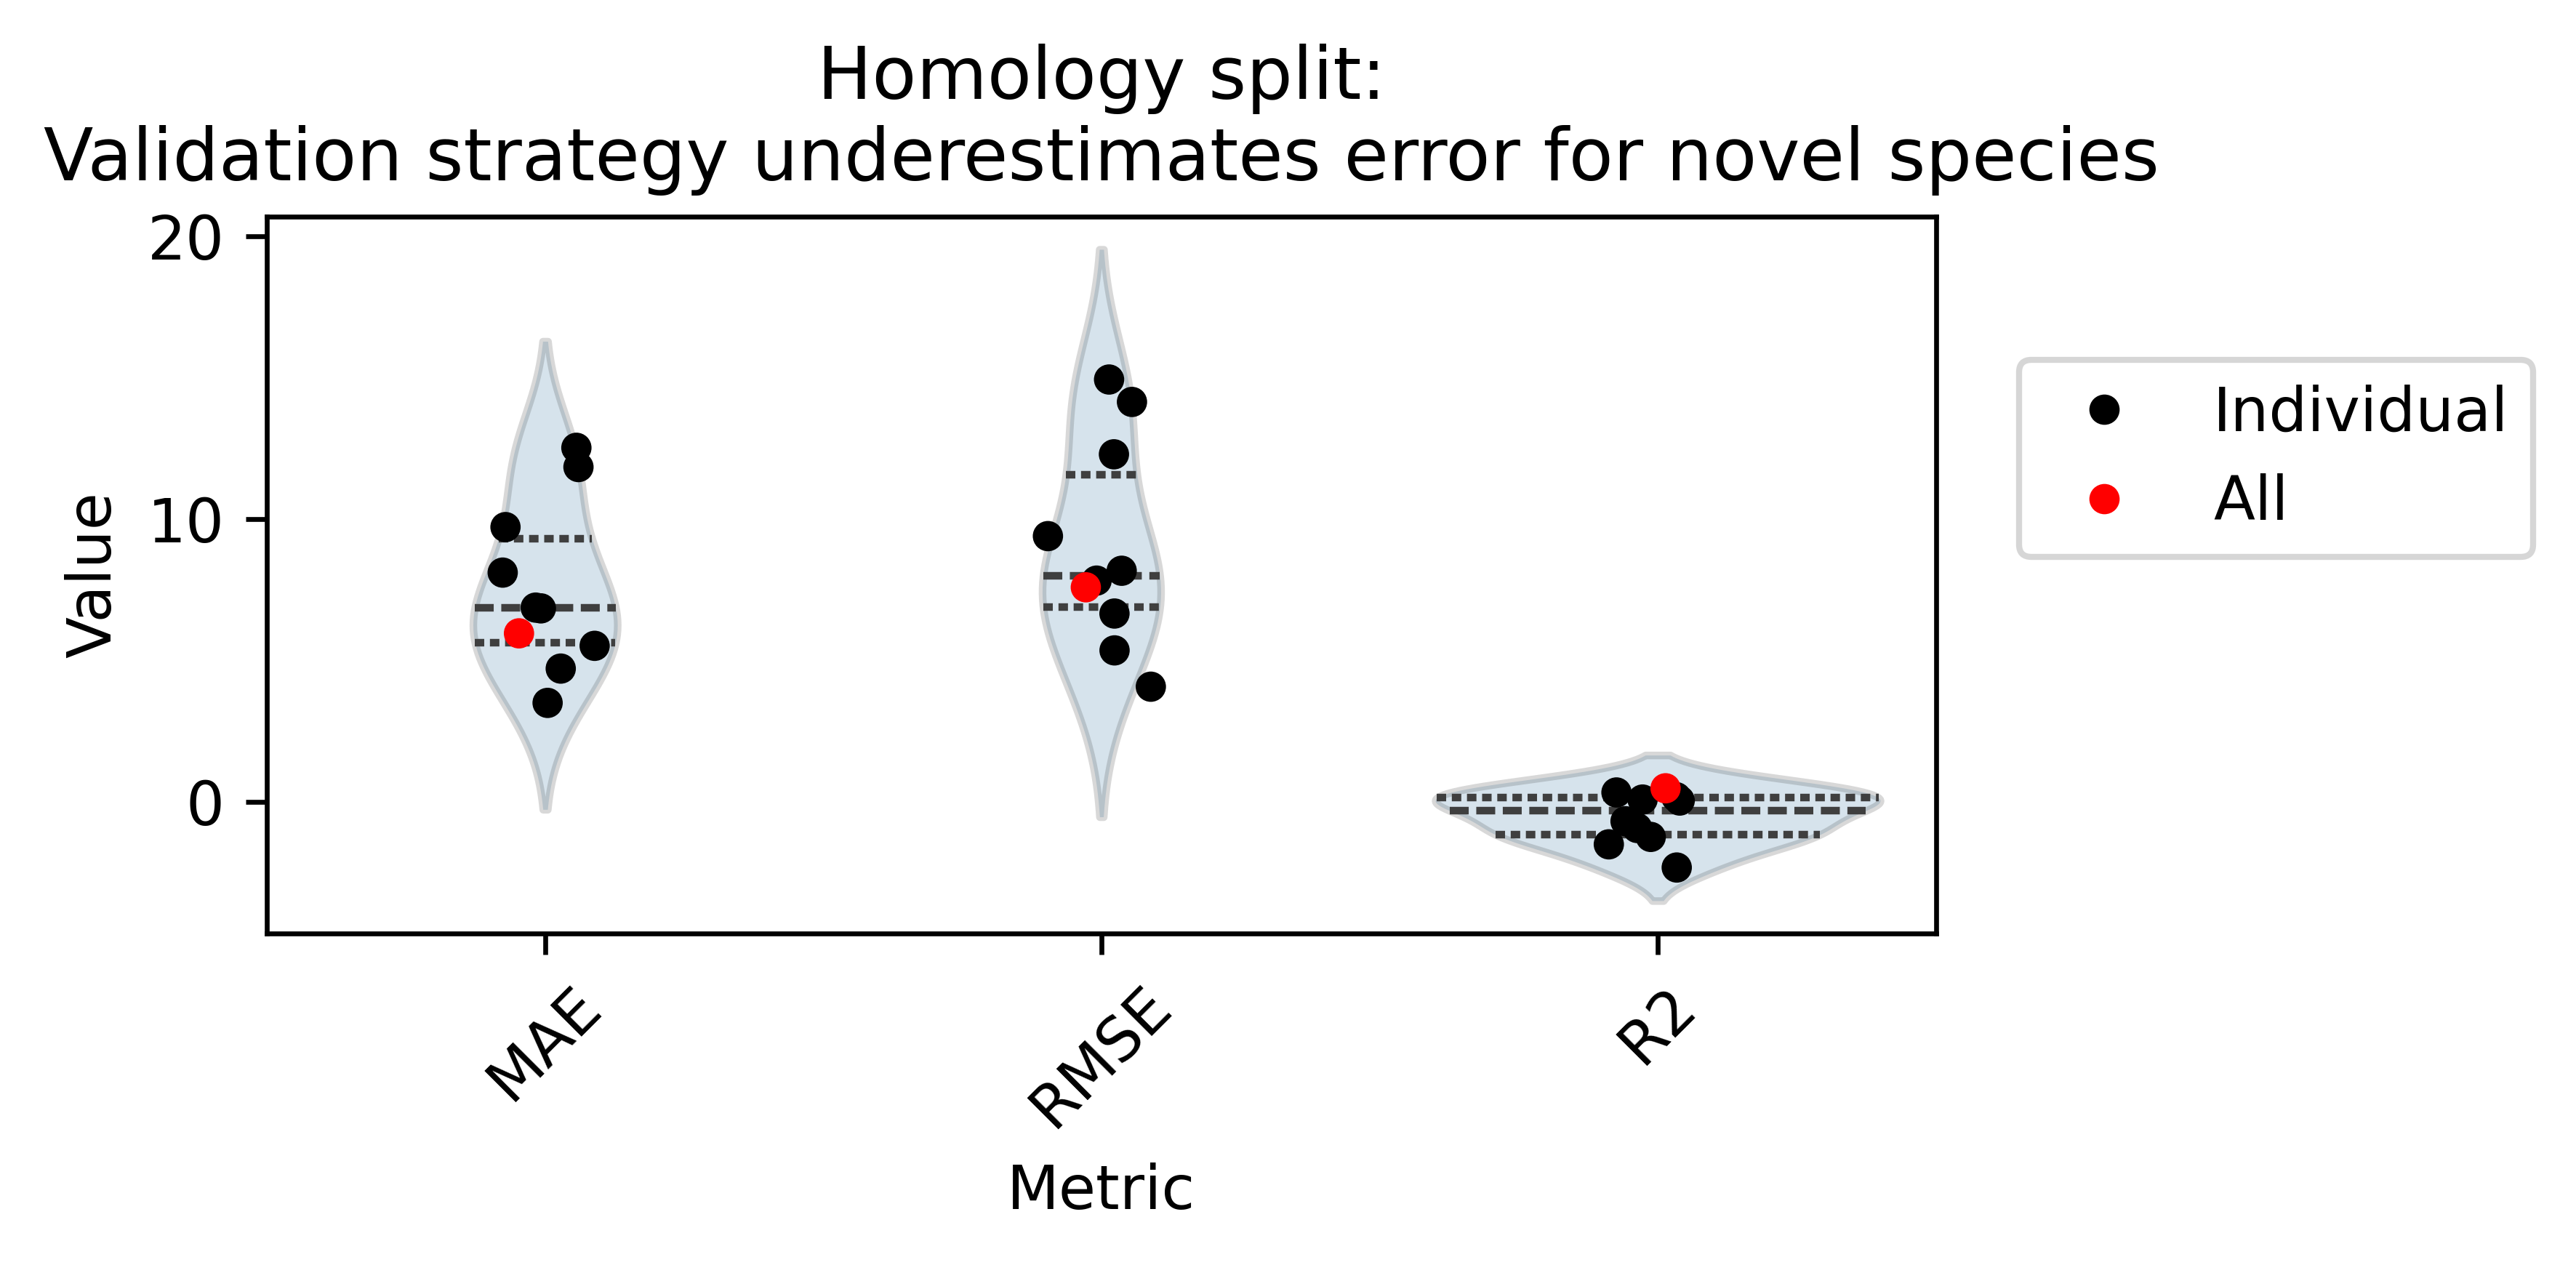

In [16]:
# Creating the boxplot
plt.figure(figsize=(6, 3))
sns.violinplot(x='Metric', y='Value', data=df_melted, alpha=0.2,inner='quart' )
plt.title('Homology split:\nValidation strategy underestimates error for novel species')
plt.xticks(rotation=45)
sns.stripplot(
    x='Metric', y='Value', data=df_melted,
    hue='color', dodge=False, palette={'red': 'red', 'black': 'black'}, jitter=True, marker='o',
)

handles, labels = plt.gca().get_legend_handles_labels()

# Combine handles and labels manually to update red point labels
species_labels = [ 'Individual', 'All']
color_labels = ['Red Points (Alpaca & Dromedary)', 'Grey Points (Other Species)']

# Use only necessary handles and labels and set them accordingly
plt.legend(
    handles[:len(species_labels)]  , # Keep species and last 2 for colors
    species_labels + color_labels,                 # Combine species and color labels
    bbox_to_anchor=(1.05, 0.8), 
    loc='upper left', 
    borderaxespad=0.
)

plt.tight_layout()
plt.savefig('../figures/homology_split.png', dpi=300, bbox_inches='tight')

plt.show()

In [17]:
plt.savefig('../figures/homology_split.png', dpi=300, bbox_inches='tight')

<Figure size 3840x2880 with 0 Axes>

In [18]:
additional_metadata = pd.read_csv('../data/raw_nbthermo_json_data.csv')

In [19]:
additional_metadata

,id,value,notes,DOI,date,last_update,changes,Tm_nanoDSF,notes_nanoDSF,Tm_DSFsypro,...,cdr3_length,fr4,modification_type,notes_modification,PDB_ID,notes_PDB,model_structure,notes_model,PDB_related,notes_PDB_related
0,1,NRL-N-C2,NaN,https://pubs.acs.org/doi/10.1021/acs.analchem....,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,WGQGTQVTVSS,NaN,NaN,NaN,NaN,NaN,NaN,7N0R,NaN
1,2,NRL-N-C2-hop,NaN,https://pubs.acs.org/doi/10.1021/acs.analchem....,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,WGQGTQVTVSS,NaN,NaN,NaN,NaN,model_AF_0002,NaN,NaN,NaN
2,3,NRL-N-E2,NaN,https://pubs.acs.org/doi/10.1021/acs.analchem....,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,WGQGTQVTVSS,NaN,NaN,NaN,NaN,NaN,NaN,7N0I,NaN
3,4,NRL-N-E2-hop,NaN,https://pubs.acs.org/doi/10.1021/acs.analchem....,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,WGQGTQVTVSS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NRL-N-E10,NaN,https://pubs.acs.org/doi/10.1021/acs.analchem....,NaN,NaN,NaN,NaN,NaN,NaN,...,21.0,WGQGTQVTVSS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,544,SP15-96-123StoR,NaN,https://doi.org/10.1371/journal.pone.0160534,NaN,NaN,NaN,NaN,NaN,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
544,545,SP15-96-123KtoI,NaN,https://doi.org/10.1371/journal.pone.0160534,NaN,NaN,NaN,NaN,NaN,58.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
545,546,SP15-96-123EKtoWI,NaN,https://doi.org/10.1371/journal.pone.0160534,NaN,NaN,NaN,NaN,NaN,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,547,SP15-96-123EStoWR,NaN,https://doi.org/10.1371/journal.pone.0160534,NaN,NaN,NaN,NaN,NaN,62.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
from sklearn.ensemble import RandomForestRegressor

### Model Diagnostics - keep it simple and use repeated K-fold cross-validation; predictors are more important.
### We would want to evaluate the model multiple times so we can be confident about using the model.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold
# Fitting Random Forest Regression to the dataset
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [21]:
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(rf_model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('Mean MAE: %.2f (%.2f)' % (scores.mean(), scores.std()))

Mean MAE: 5.29 (0.30)


In [22]:
species = ['Llama', 'Unknown', 'Camel', 'Alpaca', 'Human', 'Dromedary']
list_of_error = []
for animal in species:
    print(animal)
    x_train, y_train, x_test, y_test, x_val, y_val = split_biased(data, y, split_column='source', holdout_var = animal)
    rf_model.fit(x_train, y_train)

    ## Whithin distribution error
    rf_predictions = rf_model.predict(x_test)
    rmse=math.sqrt(mean_squared_error(y_test, rf_predictions))
    mae=mean_absolute_error(y_test, rf_predictions)
    coeff_det=r2_score(y_test, rf_predictions)

    list_of_error.append([animal, 'in-distribution', mae, rmse, coeff_det])
    
    ## Out of distribution error
    rf_predictions = rf_model.predict(x_val)
    rmse=math.sqrt(mean_squared_error(y_val, rf_predictions))
    mae=mean_absolute_error(y_val, rf_predictions)
    coeff_det=r2_score(y_val, rf_predictions)


    list_of_error.append([animal, 'out-of-distribution', mae, rmse, coeff_det])

Llama
Unknown
Camel
Alpaca
Human
Dromedary


In [23]:
results3 = pd.DataFrame(list_of_error)
results3.columns = ['Species', 'distribution','MAE', 'RMSE', 'R2']
df_melted = results3.melt(id_vars=['Species', 'distribution'], value_vars=['MAE', 'RMSE', 'R2'], var_name='Metric', value_name='Value')
df_melted['color'] = 'black'
df_melted.loc[df_melted.Species == 'all', 'color']= 'red'

In [24]:
df_melted

,Species,distribution,Metric,Value,color
0,Llama,in-distribution,MAE,5.226355,black
1,Llama,out-of-distribution,MAE,6.507178,black
2,Unknown,in-distribution,MAE,5.541048,black
3,Unknown,out-of-distribution,MAE,12.752737,black
4,Camel,in-distribution,MAE,5.474360,black
5,Camel,out-of-distribution,MAE,7.775636,black
6,Alpaca,in-distribution,MAE,6.058821,black
7,Alpaca,out-of-distribution,MAE,5.350680,black
8,Human,in-distribution,MAE,5.696734,black
9,Human,out-of-distribution,MAE,3.959465,black


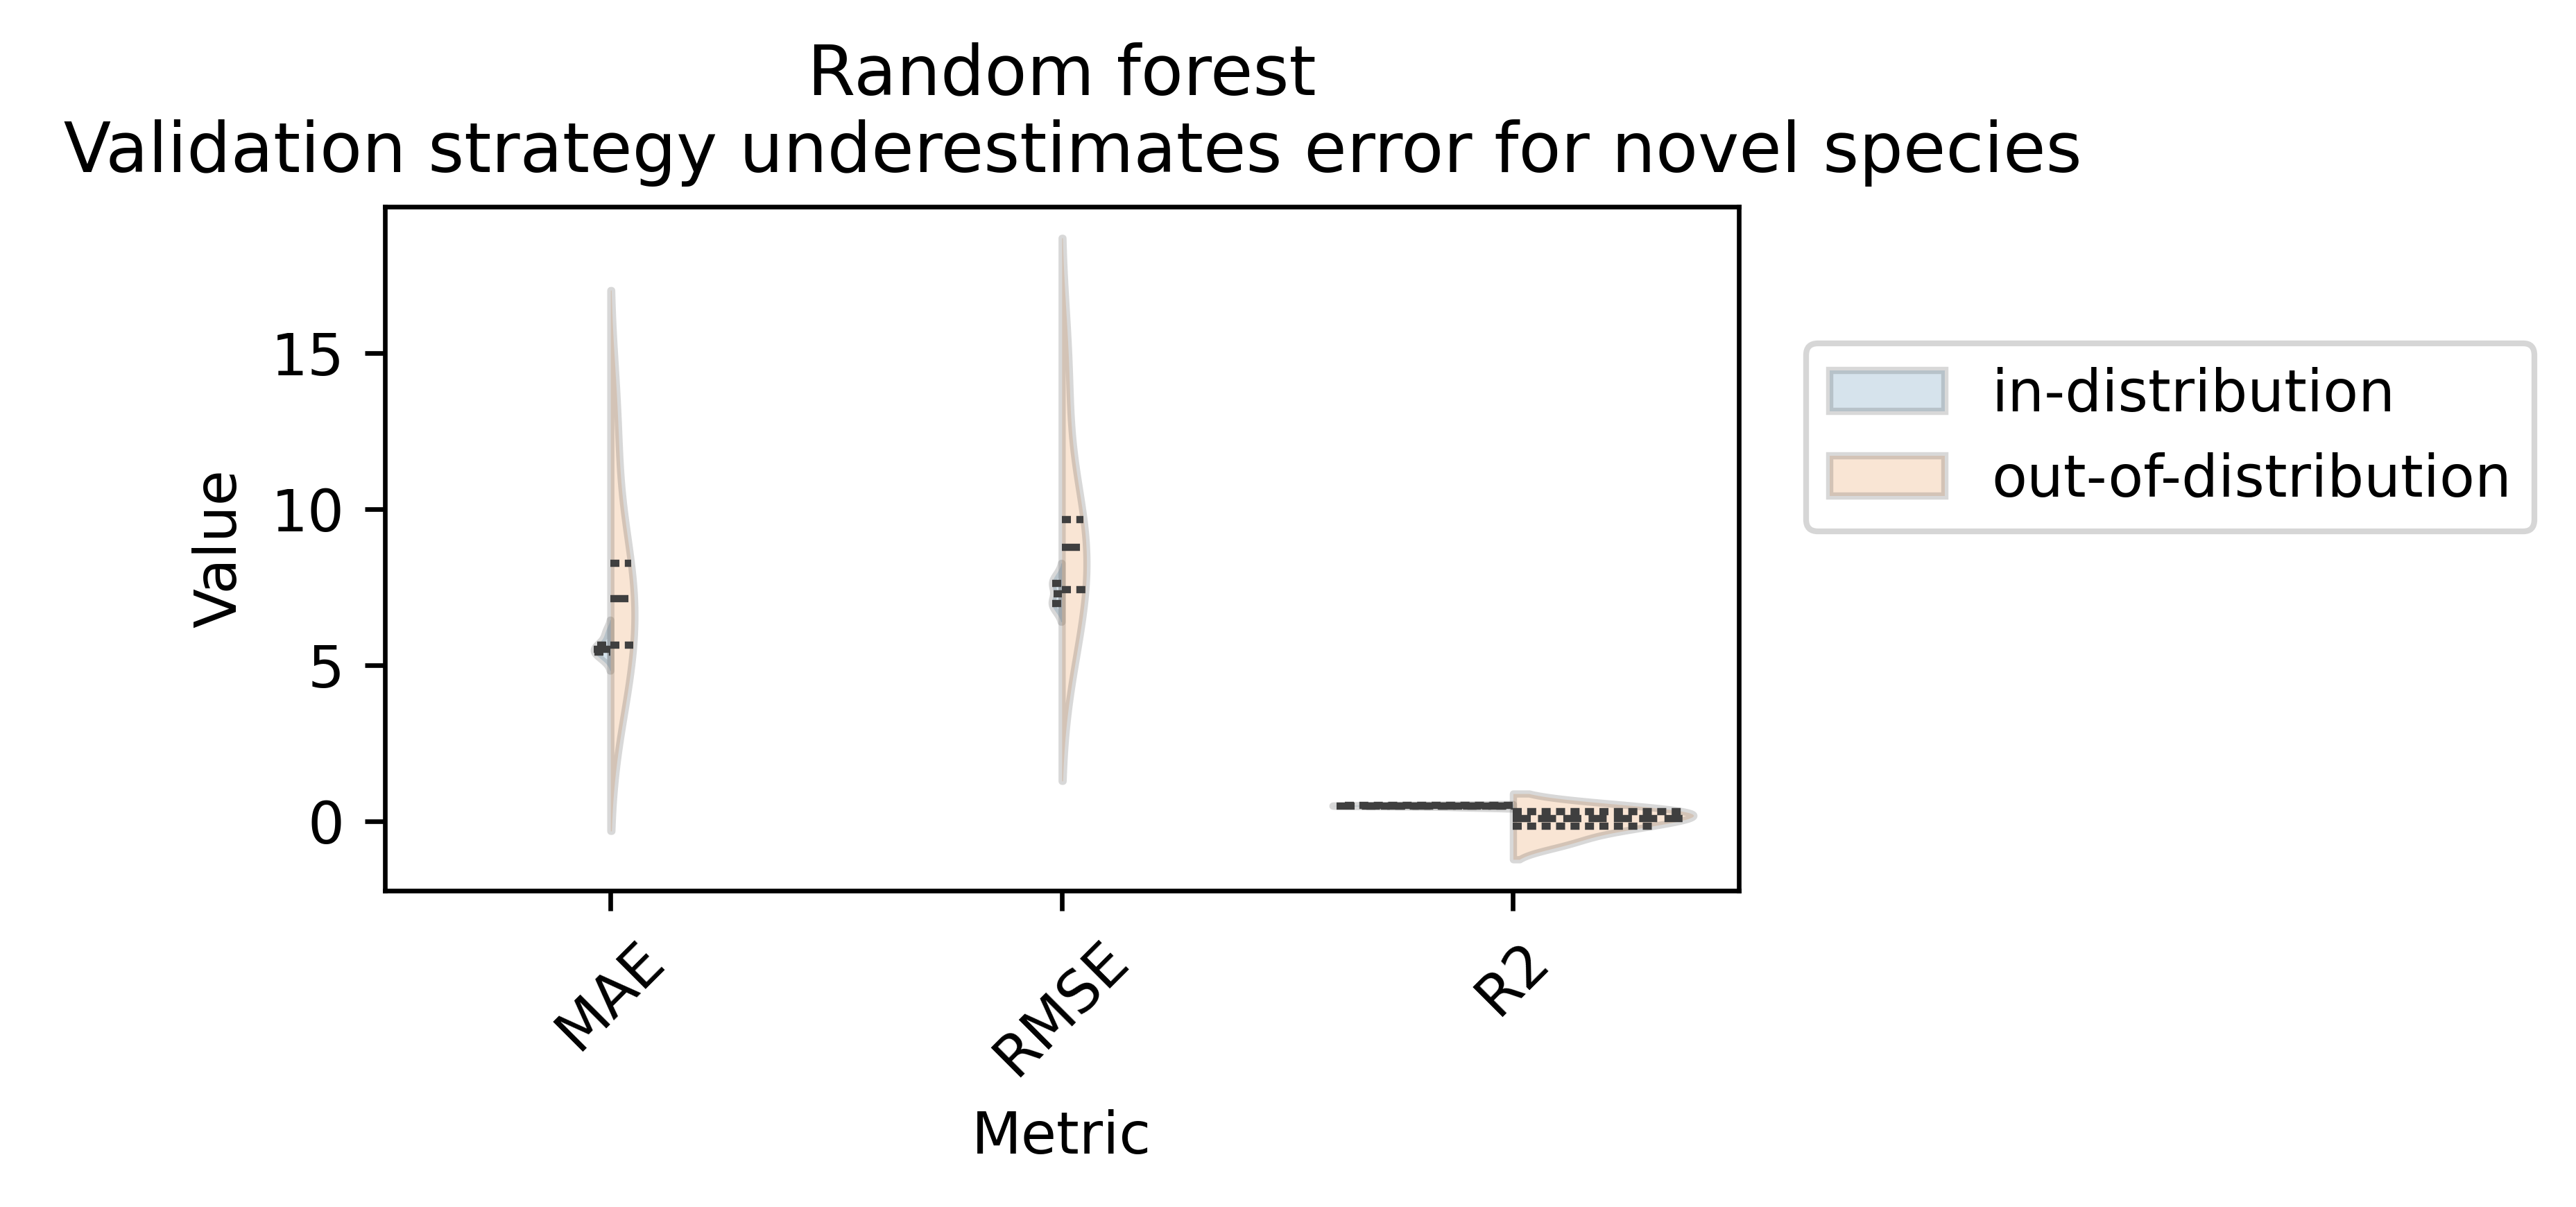

In [25]:
# Creating the boxplot
plt.figure(figsize=(6, 3))
sns.violinplot(x='Metric', y='Value', data=df_melted, alpha=0.2,inner='quart' ,split=True, hue = 'distribution')
plt.title('Random forest\n Validation strategy underestimates error for novel species')
plt.xticks(rotation=45)


handles, labels = plt.gca().get_legend_handles_labels()


# Use only necessary handles and labels and set them accordingly
plt.legend(              # Combine species and color labels
    bbox_to_anchor=(1.05, 0.8), 
    loc='upper left', 
    borderaxespad=0.
)

plt.tight_layout()
plt.savefig('../figures/random_forest.png', dpi=300, bbox_inches='tight')
plt.show()